# WF-samples start here

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import xlrd
import numpy as np

mapp='WF'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for_stdev=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    print("Number of total (including modified) peptides in "+file+" "+str(len(data.index)))
    for_stdev.append(len(data.index))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    print("Number of un-modified peptides in "+file+" "+str(len(data.index)))
    df = df.append(data)  # appends all data

total_number_of_peptides=len(df.index)
df = df.loc[(df['#Feature'] >= 4)] # sorts out if feature<4
df['count'] = 1
df = df.groupby(['Accession','Peptide']).sum()
df.reset_index(['Peptide'], inplace=True)
df['N-cut']=df['Peptide'].apply(lambda x: x[0:4]) #this can be changed to view different amounts of AA
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df = df[['Peptide', 'Mass', 'Length', 'RT', '#Feature', '#Feature WF1','#Feature WF2', '#Feature WF 3', '#Feature WF4','#Feature WF5','count', 'N-cut', 'C-cut']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['count','#Feature'], ascending=False)

print("Standard deviation: "+ str(np.std(for_stdev)))
print("Total amount of peptides "+str(total_number_of_peptides))
print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))
print("Total number of peptides with feature>=4: "+str(len(df.index)))
print("Number of peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(total_number_of_peptides))+" %")
df.head()

Number of total (including modified) peptides in peptide _WF1.xlsx 3687
Number of un-modified peptides in peptide _WF1.xlsx 3140
Number of total (including modified) peptides in peptide_WF2.xlsx 4220
Number of un-modified peptides in peptide_WF2.xlsx 3637
Number of total (including modified) peptides in peptide_WF3.xlsx 2960
Number of un-modified peptides in peptide_WF3.xlsx 2564
Number of total (including modified) peptides in peptide_WF4.xlsx 2423
Number of un-modified peptides in peptide_WF4.xlsx 2094
Number of total (including modified) peptides in peptide_WF5.xlsx 3367
Number of un-modified peptides in peptide_WF5.xlsx 2920
Standard deviation: 613.2629452363807
Total amount of peptides 14355
Average length: 12.688956433637285
Average mass: 1407.5466528416596
Total number of peptides with feature>=4: 1974
Number of peptides with feature>=4: 1974, in percent: 13.751306165099269 %


,Peptide,Mass,Length,RT,#Feature,#Feature WF1,#Feature WF2,#Feature WF 3,#Feature WF4,#Feature WF5,count,N-cut,C-cut
Accession,,,,,,,,,,,,,
sp|Q04206|TF65_HUMAN,PSLQAPVR,866.595800,8.0,14.917000,161,23.0,8.0,38.0,53.0,38.0,5,PSLQ,APVR
sp|P04406|G3P_HUMAN,AVGKVIPELNGKLTGMAF,1859.410673,18.0,73.682667,67,12.0,13.0,16.0,18.0,8.0,5,AVGK,GMAF
sp|P06727|APOA4_HUMAN,NHQLEGLTF,1058.240900,9.0,65.527167,66,10.0,15.0,13.0,15.0,13.0,5,NHQL,GLTF
sp|P06727|APOA4_HUMAN,SLAELGGHLDQQVEEF,1771.564000,16.0,99.716833,66,16.0,13.0,11.0,14.0,12.0,5,SLAE,VEEF
sp|Q14624|ITIH4_HUMAN,NFRPGVL,801.941700,7.0,39.656000,61,13.0,13.0,14.0,9.0,12.0,5,NFRP,PGVL


In [3]:
def group(list):
    grouped=[]
    nonpolar=['G','A','V','L','I','P','F','W','M']
    polar=['S','T','C','Y','N','Q']
    basic=['K','R','H']
    acidic=['D','E']
    for item in list:
        new_item=''
        for letter in item:
            if letter in nonpolar:
                new_item+='N'
            if letter in polar:
                new_item+='P'
            if letter in basic:
                new_item+='B'
            if letter in acidic:
                new_item+='A'
        grouped.append(new_item)
    return grouped

def get_letter_frequency(list):
    letters={
        'A':0,
        'G':0,
        'V':0,
        'L':0,
        'I':0,
        'P':0,
        'F':0,
        'W':0,
        'M':0,
        'S':0,
        'T':0,
        'C':0,
        'Y':0,
        'N':0,
        'Q':0,
        'K':0,
        'R':0,
        'H':0,
        'D':0,
        'E':0
    }
    for word in list:
        for letter in word:
            letters[letter] +=1
    return letters
aminoacids= get_letter_frequency(df['Peptide']*df['count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['count'])
aminoacids

{'A': 3156,
 'G': 4614,
 'V': 3622,
 'L': 5648,
 'I': 1740,
 'P': 3674,
 'F': 3450,
 'W': 256,
 'M': 965,
 'S': 3702,
 'T': 3008,
 'C': 0,
 'Y': 1143,
 'N': 1530,
 'Q': 1889,
 'K': 2060,
 'R': 1054,
 'H': 1283,
 'D': 3046,
 'E': 4533}

## Graph of aminoacid frequency in complete sequences

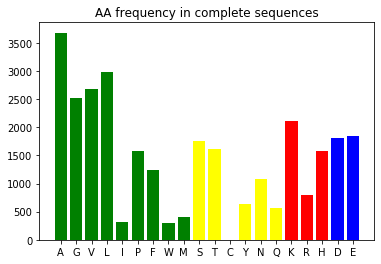

In [12]:
color=['green', 'green','green','green','green','green','green','green','green','yellow','yellow','yellow','yellow','yellow','yellow','red','red','red','blue','blue','blue']
plt.bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
plt.xticks(range(len(aminoacids)), list(aminoacids.keys()))
plt.title('AA frequency in complete sequences')
plt.show()

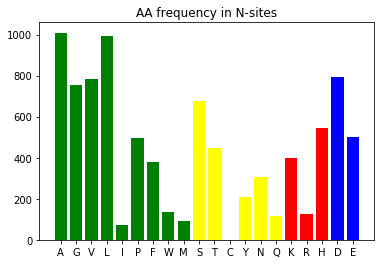

In [13]:
plt.bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
plt.xticks(range(len(N_aminoacids)), list(N_aminoacids.keys()))
plt.title('AA frequency in N-sites')
plt.show()

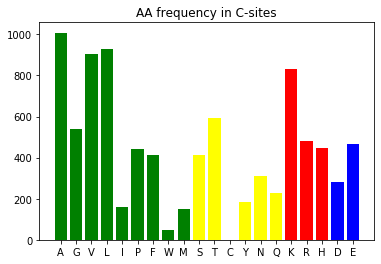

In [14]:
plt.bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
plt.xticks(range(len(C_aminoacids)), list(C_aminoacids.keys()))
plt.title('AA frequency in C-sites')
plt.show()

### How does feature and count correlate in these samples? Are there certain peptides with abnormal feature?

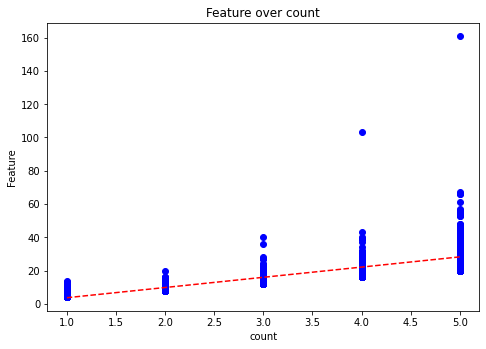

[ 6.12735666 -2.34968614]


In [281]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['#Feature'], color='b')
z = np.polyfit(df['count'], df['#Feature'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Feature')
ax.set_title('Feature over count')
plt.show()
print(z)

In [282]:
df.sort_values(['#Feature'], ascending=False).head()

,Peptide,Mass,Length,RT,#Feature,#Feature WF1,#Feature WF2,#Feature WF 3,#Feature WF4,#Feature WF5,count,N-cut,C-cut
Accession,,,,,,,,,,,,,
sp|Q04206|TF65_HUMAN,PSLQAPVR,866.595800,8.0,14.917000,161,23.0,8.0,38.0,53.0,38.0,5,PSLQ,APVR
sp|P01009|A1AT_HUMAN,AVLTIDEKGTEAAGAMF,1738.844700,17.0,67.552500,103,6.0,0.0,47.0,12.0,38.0,4,AVLT,GAMF
sp|P04406|G3P_HUMAN,AVGKVIPELNGKLTGMAF,1859.410673,18.0,73.682667,67,12.0,13.0,16.0,18.0,8.0,5,AVGK,GMAF
sp|P06727|APOA4_HUMAN,NHQLEGLTF,1058.240900,9.0,65.527167,66,10.0,15.0,13.0,15.0,13.0,5,NHQL,GLTF
sp|P06727|APOA4_HUMAN,SLAELGGHLDQQVEEF,1771.564000,16.0,99.716833,66,16.0,13.0,11.0,14.0,12.0,5,SLAE,VEEF


### What are the most frequent N,C-terminals and what is their sequence? How often are they found? Are there outliers? OOPS: Mass length etc are fucked

In [330]:
#Here we sort on the C and N-cut

df_N=df.groupby(['Accession', 'N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
#sorted by accession and then C-cut. KGEE is found 48 times in APOC2
df_C=df.groupby(['Accession', 'C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C=df_C.sort_values(['count'], ascending=False)

df_C.head()


#Feature  #Feature Sample 13  \
Accession                               C-cut                                 
sp|P69905|HBA_HUMAN                     LHAH        373               165.0   
                                        MPNA        250                79.0   
                                        ALER        181                63.0   
                                        AHKL        118                16.0   
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN HKYH        259                65.0   

                                               #Feature Sample 21  \
Accession                               C-cut                       
sp|P69905|HBA_HUMAN                     LHAH                179.0   
                                        MPNA                 91.0   
                                        ALER                 55.0   
                                        AHKL                 62.0   
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN HKYH                 61.0   

                                               #Feature Sample 33  count  
Accession                               C-cut                             
sp|P69905|HBA_HUMAN                     LHAH                 27.0     38  
                                        MPNA                 80.0     30  
                                        ALER                 63.0     30  
                                        AHKL                 40.0     21  
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN HKYH                133.0     21

N_count: 72 , C_count: 79


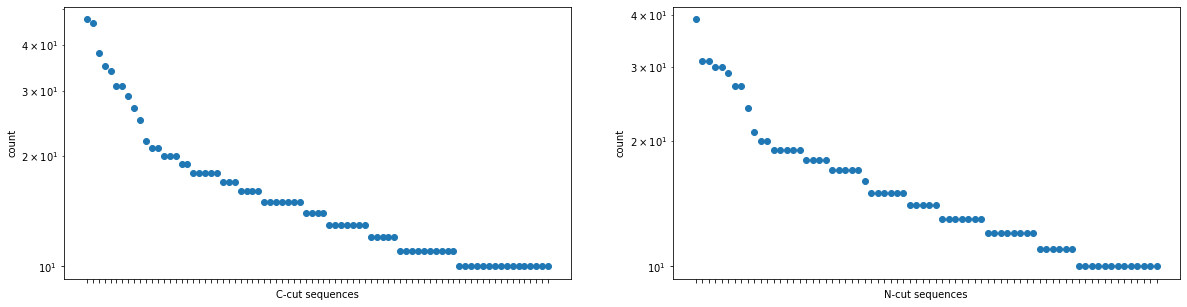

In [285]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

df_N.reset_index(['Accession'], inplace=True)
df_C.reset_index(['Accession'], inplace=True)
N_count_10=len(df_N.loc[(df_N['count'] >= 10)].index)
C_count_10=len(df_C.loc[(df_C['count'] >= 10)].index)
df_N = df_N.loc[(df_N['count'] >= 10)] 
df_C = df_C.loc[(df_C['count'] >= 10)] 
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[1].set_yscale('log')           
ax[0].set_yscale('log')  
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
ax[1].scatter(df_N.index, df_N['count']) #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['count']) #row=1, col=0
print("N_count: "+str(N_count_10)+" , C_count: "+str(C_count_10))

### What are the most frequent groups of AA at the N,C-terminal? Are there any favoured combinations?

In [313]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.

#might be an easier way to code

df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','#Feature'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead

df_N=df_N.sort_values(['count','#Feature'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','#Feature'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()


df_C=df_C.sort_values(['count','#Feature'], ascending=False)
df_N.head()

,#Feature,#Feature Sample 13,#Feature Sample 21,#Feature Sample 33,count
N-grouped,,,,,
NNNN,477,77.0,168.0,232.0,89
PNNN,277,36.0,55.0,186.0,56
NNBN,350,44.0,52.0,254.0,53
NNPN,287,61.0,80.0,146.0,51
NNNP,329,75.0,113.0,141.0,50


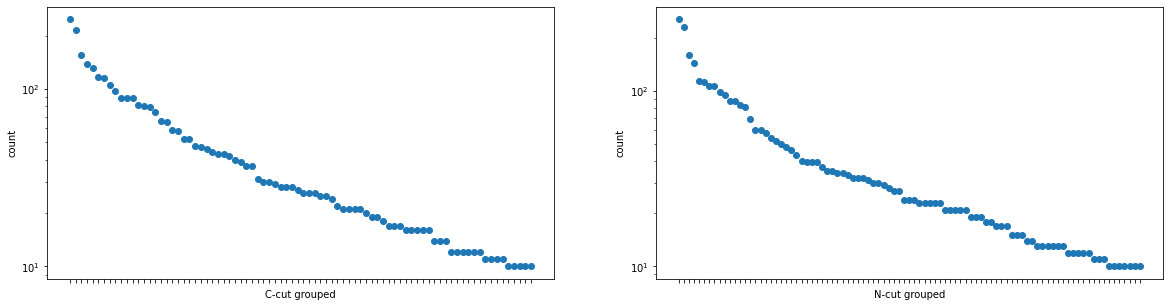

In [100]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
df_N = df_N.loc[(df_N['count'] >= 10)] 
df_C = df_C.loc[(df_C['count'] >= 10)] 
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[1].set_yscale('log')           
ax[0].set_yscale('log')  
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
ax[1].scatter(df_N.index, df_N['count']) #row=0, col=0
ax[0].scatter(df_C.index, df_C['count']) #row=1, col=0


# Infected samples start here

In [9]:
# !!NOW STARTS THE ANALYSIS OF THE INFECTED PATIENTS!!
# !!NOW STARTS THE ANALYSIS OF THE INFECTED PATIENTS!!
# !!NOW STARTS THE ANALYSIS OF THE INFECTED PATIENTS!!
# !!NOW STARTS THE ANALYSIS OF THE INFECTED PATIENTS!!

mapp='peptide_sample_inf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for_stdev=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    for_stdev.append(len(data.index))
    print("Number of modified peptides in "+file+" "+str(len(data.index)))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    print("Number of un-modified peptides in "+file+" "+str(len(data.index)))
    df = df.append(data)  # appends all data

total_number_of_peptides=total_number_of_peptides=len(df.index)
df = df.loc[(df['#Feature'] >= 4)] # sorts out if feature<4
df['count'] = 1
df = df.groupby(['Accession','Peptide']).sum()
df.reset_index(['Peptide'], inplace=True)
df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df = df[['Peptide', 'Mass', 'Length', 'RT', '#Feature', '#Feature Sample 31','#Feature Sample 34', '#Feature Sample 39','count', 'N-cut', 'C-cut']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['count','#Feature'], ascending=False)
print("Standard deviation: "+str(np.std(for_stdev)))
print("Total amount of peptides "+str(total_number_of_peptides))
print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))
print("Total number of peptides with feature>=4: "+str(len(df.index)))
print("Number of peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(total_number_of_peptides))+" %")
aminoacids= get_letter_frequency(df['Peptide']*df['count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['count'])
print(aminoacids)
df.head()

Number of modified peptides in peptide_sample_31.xlsx 5103
Number of un-modified peptides in peptide_sample_31.xlsx 4055
Number of modified peptides in peptide_sample_34.xlsx 1412
Number of un-modified peptides in peptide_sample_34.xlsx 1218
Number of modified peptides in peptide_sample_39.xlsx 4929
Number of un-modified peptides in peptide_sample_39.xlsx 3817
Standard deviation: 1700.4262864221887
Total amount of peptides 9090
Average length: 13.731363331094695
Average mass: 1494.5794611588162
Total number of peptides with feature>=4: 1489
Number of peptides with feature>=4: 1489, in percent: 16.38063806380638 %
{'A': 3679, 'G': 2527, 'V': 2677, 'L': 2982, 'I': 320, 'P': 1577, 'F': 1232, 'W': 307, 'M': 413, 'S': 1751, 'T': 1605, 'C': 0, 'Y': 633, 'N': 1085, 'Q': 570, 'K': 2102, 'R': 799, 'H': 1578, 'D': 1813, 'E': 1852}


,Peptide,Mass,Length,RT,#Feature,#Feature Sample 31,#Feature Sample 34,#Feature Sample 39,count,N-cut,C-cut
Accession,,,,,,,,,,,
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1251.1440,12.0,86.333333,115,40.0,15.0,60.0,3,AGVA,HKYH
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.9429,11.0,75.975000,109,42.0,12.0,55.0,3,GVAN,HKYH
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.8530,9.0,59.131667,96,35.0,9.0,52.0,3,ANAL,HKYH
sp|P68871|HBB_HUMAN,VHLTPEEKSAV,1208.6400,11.0,50.666667,78,28.0,14.0,36.0,3,VHLT,KSAV
sp|P69905|HBA_HUMAN,STVLTSKYR,1053.5818,9.0,119.810000,77,21.0,15.0,41.0,3,STVL,SKYR


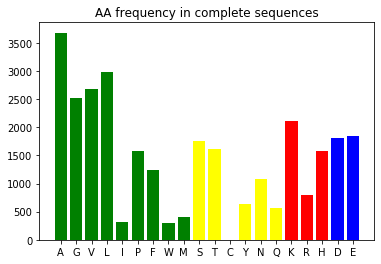

In [15]:
plt.bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
plt.xticks(range(len(aminoacids)), list(aminoacids.keys()))
plt.title('AA frequency in complete sequences')
plt.show()

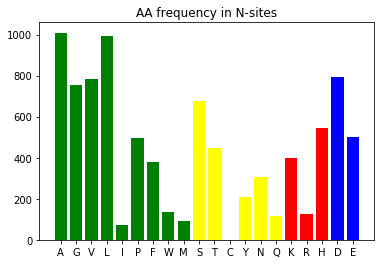

In [16]:
plt.bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
plt.xticks(range(len(N_aminoacids)), list(N_aminoacids.keys()))
plt.title('AA frequency in N-sites')
plt.show()

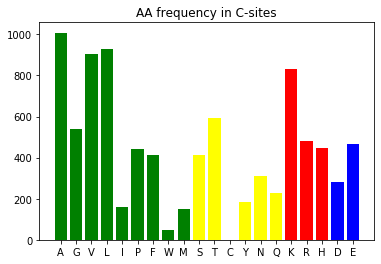

In [17]:
plt.bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
plt.xticks(range(len(C_aminoacids)), list(C_aminoacids.keys()))
plt.title('AA frequency in C-sites')
plt.show()

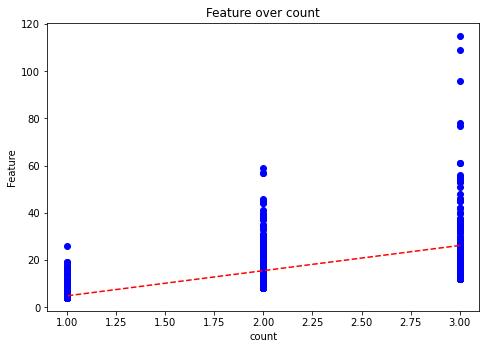

[10.675688   -5.88063833]


In [106]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['#Feature'], color='b')
z = np.polyfit(df['count'], df['#Feature'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Feature')
ax.set_title('Feature over count')
plt.show()
print(z)

In [218]:
df.sort_values(['#Feature'], ascending=False).head()

,Peptide,Mass,Length,RT,#Feature,#Feature Sample 31,#Feature Sample 34,#Feature Sample 39,count,N-cut,C-cut
Accession,,,,,,,,,,,
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1251.1440,12.0,86.333333,115,40.0,15.0,60.0,3,AGVA,HKYH
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.9429,11.0,75.975000,109,42.0,12.0,55.0,3,GVAN,HKYH
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.8530,9.0,59.131667,96,35.0,9.0,52.0,3,ANAL,HKYH
sp|P68871|HBB_HUMAN,VHLTPEEKSAV,1208.6400,11.0,50.666667,78,28.0,14.0,36.0,3,VHLT,KSAV
sp|P69905|HBA_HUMAN,STVLTSKYR,1053.5818,9.0,119.810000,77,21.0,15.0,41.0,3,STVL,SKYR


In [319]:
#Here we sort on the C and N-cut

df_N=df.groupby(['Accession', 'N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
#sorted by accession and then C-cut. KGEE is found 48 times in APOC2
df_C=df.groupby(['Accession', 'C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C=df_C.sort_values(['count'], ascending=False)

df_C.head()


#Feature  #Feature Sample 31  #Feature Sample 34  \
Accession           C-cut                                                     
sp|P69905|HBA_HUMAN LSAL        439               171.0                32.0   
                    ALER        281               129.0                48.0   
sp|P68871|HBB_HUMAN GTFA        354               145.0                20.0   
sp|P69905|HBA_HUMAN SKYR        391               105.0                40.0   
                    LERM        549               233.0                17.0   

                           #Feature Sample 39  count  
Accession           C-cut                             
sp|P69905|HBA_HUMAN LSAL                236.0     39  
                    ALER                103.0     38  
sp|P68871|HBB_HUMAN GTFA                189.0     36  
sp|P69905|HBA_HUMAN SKYR                246.0     35  
                    LERM                299.0     35

N_count: 56, C_count: 56


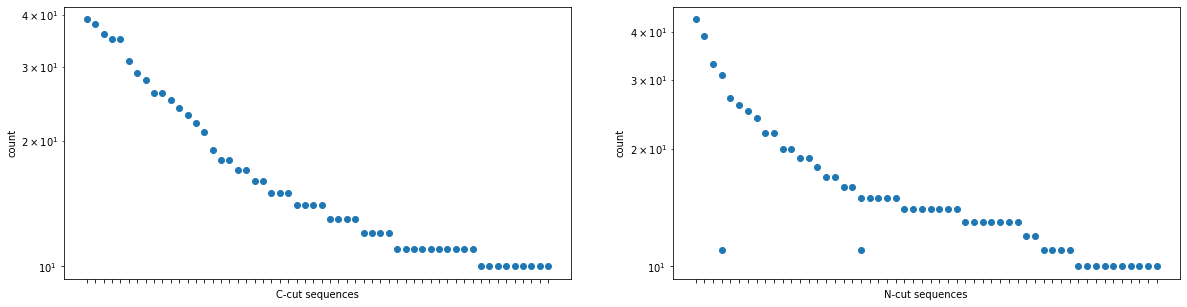

In [223]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

#df_N.reset_index(['Accession'], inplace=True)
#df_C.reset_index(['Accession'], inplace=True)
N_count_10=len(df_N.loc[(df_N['count'] >= 10)].index)
C_count_10=len(df_C.loc[(df_C['count'] >= 10)].index)
df_N = df_N.loc[(df_N['count'] >= 10)] 
df_C = df_C.loc[(df_C['count'] >= 10)] 
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[1].set_yscale('log')           
ax[0].set_yscale('log')  
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
ax[1].scatter(df_N.index, df_N['count']) #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['count']) #row=1, col=0
print("N_count: "+str(C_count_10)+ ", C_count: "+str(N_count_10))

In [320]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.

#might be an easier way to code

df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','#Feature'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead

df_N=df_N.sort_values(['count','#Feature'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','#Feature'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()


df_C=df_C.sort_values(['count','#Feature'], ascending=False)
df_N.head()

,#Feature,#Feature Sample 31,#Feature Sample 34,#Feature Sample 39,count
N-grouped,,,,,
NNBN,700,314.0,34.0,352.0,99
NNPN,767,328.0,64.0,375.0,90
NNNB,670,278.0,52.0,339.0,86
NBNP,592,225.0,57.0,310.0,75
PNNN,422,123.0,25.0,274.0,71


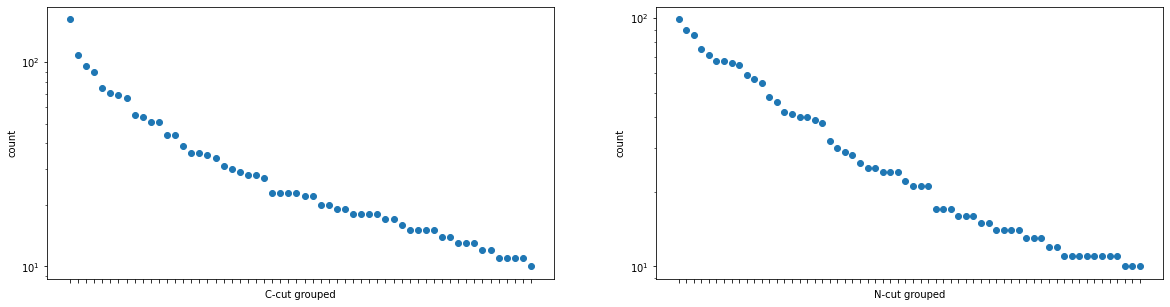

In [114]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
df_N = df_N.loc[(df_N['count'] >= 10)] 
df_C = df_C.loc[(df_C['count'] >= 10)] 
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[1].set_yscale('log')           
ax[0].set_yscale('log')  
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
ax[1].scatter(df_N.index, df_N['count']) #row=0, col=0
ax[0].scatter(df_C.index, df_C['count']) #row=1, col=0


# Non-infected samples start here

In [322]:
# !!NOW STARTS THE ANALYSIS OF THE NONINFECTED PATIENTS!!
# !!NOW STARTS THE ANALYSIS OF THE NONINFECTED PATIENTS!!
# !!NOW STARTS THE ANALYSIS OF THE NONINFECTED PATIENTS!!
# !!NOW STARTS THE ANALYSIS OF THE NONINFECTED PATIENTS!!

mapp='peptide_sample_ninf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for_stdev=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    for_stdev.append(len(data.index))
    print("Number of modified peptides in "+file+" "+str(len(data.index)))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    print("Number of un-modified peptides in "+file+" "+str(len(data.index)))
    df = df.append(data)  # appends all data

total_number_of_peptides=total_number_of_peptides=len(df.index)
df = df.loc[(df['#Feature'] >= 4)] # sorts out if feature<4
df['count'] = 1
df = df.groupby(['Accession','Peptide']).sum()
df.reset_index(['Peptide'], inplace=True)
df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df = df[['Peptide', 'Mass', 'Length', 'RT', '#Feature', '#Feature Sample 13','#Feature Sample 21', '#Feature Sample 33','count', 'N-cut', 'C-cut']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['count','#Feature'], ascending=False)

print("Standard deviation: "+str(np.std(for_stdev)))
print("Total amount of peptides "+str(total_number_of_peptides))
print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))
print("Total number of peptides with feature>=4: "+str(len(df.index)))
print("Number of peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(total_number_of_peptides))+" %")
aminoacids= get_letter_frequency(df['Peptide']*df['count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['count'])
df.head()

Number of modified peptides in peptide_sample_13.xlsx 3146
Number of un-modified peptides in peptide_sample_13.xlsx 2638
Number of modified peptides in peptide_sample_21.xlsx 4863
Number of un-modified peptides in peptide_sample_21.xlsx 4076
Number of modified peptides in peptide_sample_33.xlsx 4277
Number of un-modified peptides in peptide_sample_33.xlsx 3476
Standard deviation: 712.6356401103972
Total amount of peptides 10190
Average length: 12.375892857142857
Average mass: 1352.1624395512686
Total number of peptides with feature>=4: 1120
Number of peptides with feature>=4: 1120, in percent: 10.991167811579981 %


,Peptide,Mass,Length,RT,#Feature,#Feature Sample 13,#Feature Sample 21,#Feature Sample 33,count,N-cut,C-cut
Accession,,,,,,,,,,,
sp|P02671|FIBA_HUMAN,MELERPGGNEITR,1509.224925,13.0,55.168333,94,18.0,35.0,40.0,3,MELE,EITR
sp|P02671|FIBA_HUMAN,MELERPGGNEIT,1353.123825,12.0,64.688333,69,18.0,32.0,18.0,3,MELE,NEIT
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.525000,9.0,57.370000,46,8.0,12.0,26.0,3,ANAL,HKYH
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.778900,11.0,85.286667,46,13.0,13.0,20.0,3,GVAN,HKYH
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1250.652000,12.0,96.916667,41,11.0,12.0,18.0,3,AGVA,HKYH


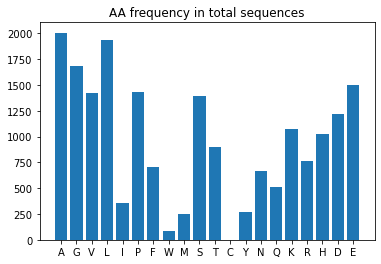

In [201]:
plt.bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
plt.xticks(range(len(aminoacids)), list(aminoacids.keys()))
plt.title('AA frequency in total sequences')
plt.show()

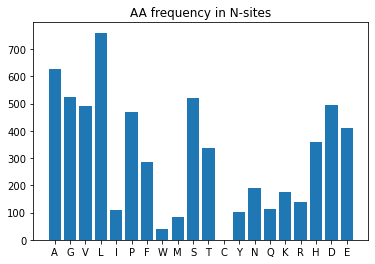

In [168]:
plt.bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
plt.xticks(range(len(N_aminoacids)), list(N_aminoacids.keys()))
plt.title('AA frequency in N-sites')
plt.show()

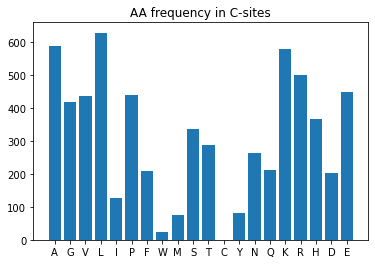

In [169]:
plt.bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
plt.xticks(range(len(C_aminoacids)), list(C_aminoacids.keys()))
plt.title('AA frequency in C-sites')
plt.show()

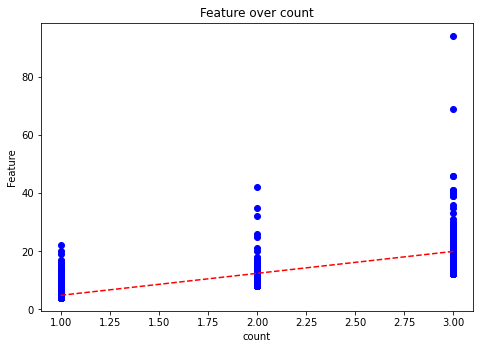

[ 7.55047414 -2.73092742]


In [119]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['#Feature'], color='b')
z = np.polyfit(df['count'], df['#Feature'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Feature')
ax.set_title('Feature over count')
plt.show()
print(z)

In [260]:
df.sort_values(['#Feature'], ascending=False).head()

,Peptide,Mass,Length,RT,#Feature,#Feature Sample 13,#Feature Sample 21,#Feature Sample 33,count,N-cut,C-cut
Accession,,,,,,,,,,,
sp|P02671|FIBA_HUMAN,MELERPGGNEITR,1509.224925,13.0,55.168333,94,18.0,35.0,40.0,3,MELE,EITR
sp|P02671|FIBA_HUMAN,MELERPGGNEIT,1353.123825,12.0,64.688333,69,18.0,32.0,18.0,3,MELE,NEIT
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.525000,9.0,57.370000,46,8.0,12.0,26.0,3,ANAL,HKYH
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.778900,11.0,85.286667,46,13.0,13.0,20.0,3,GVAN,HKYH
sp|P69905|HBA_HUMAN,AHVDDMPNALSALSDLHAH,2021.426875,19.0,95.971250,42,23.0,19.0,0.0,2,AHVD,LHAH


In [332]:
#Here we sort on the C and N-cut

df_N=df.groupby(['Accession', 'N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
#sorted by accession and then C-cut. KGEE is found 48 times in APOC2
df_C=df.groupby(['Accession', 'C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C=df_C.sort_values(['count'], ascending=False)

df_N.head()


#Feature  #Feature Sample 13  #Feature Sample 21  \
Accession           N-cut                                                     
sp|P69905|HBA_HUMAN VLSP        134                35.0                48.0   
                    TYFP        124                19.0                48.0   
                    VGAH        130                43.0                42.0   
sp|P68871|HBB_HUMAN VHLT        123                31.0                47.0   
sp|P69905|HBA_HUMAN LTNA        145                55.0                47.0   

                           #Feature Sample 33  count  
Accession           N-cut                             
sp|P69905|HBA_HUMAN VLSP                 51.0     22  
                    TYFP                 57.0     21  
                    VGAH                 45.0     20  
sp|P68871|HBB_HUMAN VHLT                 45.0     19  
sp|P69905|HBA_HUMAN LTNA                 43.0     16

N_count: 22, C_count: 20


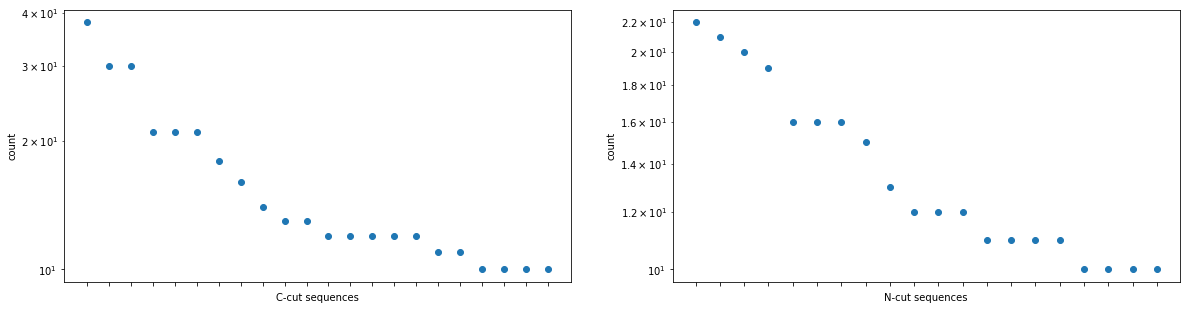

In [232]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

df_N.reset_index(['Accession'], inplace=True)
df_C.reset_index(['Accession'], inplace=True)
N_count_10=len(df_N.loc[(df_N['count'] >= 10)].index)
C_count_10=len(df_C.loc[(df_C['count'] >= 10)].index)
df_N = df_N.loc[(df_N['count'] >= 10)] 
df_C = df_C.loc[(df_C['count'] >= 10)] 
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[1].set_yscale('log')           
ax[0].set_yscale('log')  
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
ax[1].scatter(df_N.index, df_N['count']) #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['count']) #row=1, col=0
print("N_count: "+str(C_count_10)+ ", C_count: "+str(N_count_10))

In [328]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.

#might be an easier way to code

df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','#Feature'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead

df_N=df_N.sort_values(['count','#Feature'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','#Feature'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()


df_C=df_C.sort_values(['count','#Feature'], ascending=False)
df_C.head()

,#Feature,#Feature Sample 13,#Feature Sample 21,#Feature Sample 33,count
C-grouped,,,,,
NNNB,512,132.0,165.0,215.0,106
NBNB,604,207.0,273.0,122.0,76
NNPN,449,102.0,138.0,209.0,66
NNAB,303,84.0,94.0,125.0,53
NPNB,288,70.0,118.0,100.0,53


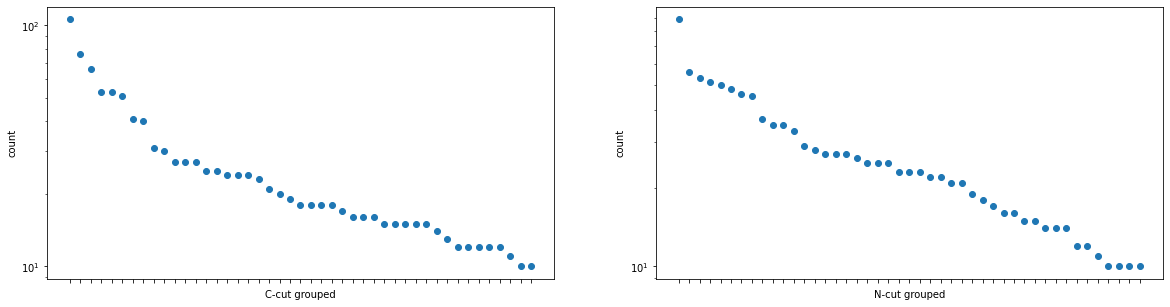

In [325]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
df_N = df_N.loc[(df_N['count'] >= 10)] 
df_C = df_C.loc[(df_C['count'] >= 10)] 
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[1].set_yscale('log')           
ax[0].set_yscale('log')  
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')
ax[1].scatter(df_N.index, df_N['count']) #row=0, col=0
ax[0].scatter(df_C.index, df_C['count']) #row=1, col=0
